In [2]:
# Allen Visual Behaviour SWR Collection Script
# Called by a bash script
# Produces SWR events at a 2.5 zscore threshold
# also produces time series lsiting gamma band events (minimum 0.015 s long) and motion artifacts on a channel outside brain
# TO DO:  Interpolate between all the channels some how and merge the lfp signals from ca1 into a big 6 by samples array to run the detector on.

# Technical details of this dataset are located here: https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/f7/06/f706855a-a3a1-4a3a-a6b0-3502ad64680f/visualbehaviorneuropixels_technicalwhitepaper.pdf
# IF that link does not work this url can also work: https://portal.brain-map.org/explore/circuits/visual-behavior-neuropixels 



"""
    This code calls the Neuropixels LFP data from the visual behaviour
    datasets and loops through it storing channels used as well as
    the.
    
    The methods are based on a combination of methods taken from De Filliopo et al., (2022), Nitzan et al., (2020) which were both used on the ABA and IBL datasets for 
    detecting ripples while the mouse was still.  Methods for improving detectors so that putative ripples occuring during movement could be detected are based on 
    criteria from Frank and Chen (2008) as well as
"""



# change this as needed:
sdk_cache_dir='/space/scratch/allen_visbehave_data'# path to where the cache for the allensdk is (wehre the lfp is going)
output_dir = '/space/scratch/allen_visbehave_swr_data'
swr_output_dir = 'testing_dir' # directory specifying the output

# example input
#select_these_sessions = []
only_brain_observatory_sessions = True # if true only sessions from the brain observatory will be used
#select_these_sessions = [715093703, 719161530, 721123822]
select_these_sessions = [715093703]
#select_these_sessions = [746083955] # the first screwed up when selecting a probe. Session id 
#select_these_sessions = [816200189] # this one messed up when doing the movement artifact detection at probe 836943715
dont_wipe_these_sessions = []


# THRESHOLDS
gamma_event_thresh = 3 # zscore threshold for gamma events

# gamma filters are same as default for now
gamma_filters_paths = ["/home/acampbell/Stienmetz2019Reanalyzed/ExtractingSWRs/PowerBandFilters/Gamma_Band_withlowpass_Filter/lowpass_prefilter.npy",
                    "/home/acampbell/Stienmetz2019Reanalyzed/ExtractingSWRs/PowerBandFilters/Gamma_Band_withlowpass_Filter/gamma_band_filter.npy"]
ripple_band_threshold = 2 # note this defines the threshold for envelopes, from these events identify ones with peaks that pass a peak-power threshold as well
movement_artifact_ripple_band_threshold = 3


# libraries
import os
import subprocess 
import numpy as np
import pandas as pd
from scipy import io, signal
#from fitter import Fitter, get_common_distributions, get_distributions
import scipy.ndimage
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
# for ripple detection
import ripple_detection
from ripple_detection import filter_ripple_band
import ripple_detection.simulate as ripsim # for making our time vectors
import piso #can be difficult to install, https://piso.readthedocs.io/en/latest/
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from tqdm import tqdm
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from scipy import interpolate
from scipy.signal import firwin, lfilter


# functions

# subprocess is a default module
def call_bash_function(bash_command = ""):
    #example bash comand:
    #bash_command = "source /path/to/your/bash_script.sh && your_bash_function"
    process = subprocess.Popen(bash_command, stdout=subprocess.PIPE, shell=True)
    output, error = process.communicate()

    if process.returncode == 0:
        print("Bash function executed successfully.")
        print("Output:", output.decode('utf-8'))
    else:
        print("Error:", error.decode('utf-8'))

# Assuming you have your signal_array, b, and a defined as before
def finitimpresp_filter_for_LFP(LFP_array, samplingfreq, lowcut = 1, highcut = 250,
                    filter_order = 101):
    
    nyquist = 0.5 * samplingfreq

    # Design the FIR bandpass filter using scipy.signal.firwin
    fir_coeff = signal.firwin(filter_order, [lowcut / nyquist, highcut / nyquist],
                              pass_zero=False, fs=samplingfreq)

    # Apply the FIR filter to your signal_array
    #filtered_signal = signal.convolve(LFP_array, fir_coeff, mode='same', method='auto')
    filtered_signal = signal.lfilter(fir_coeff, 1.0, LFP_array, axis=0)
    return(filtered_signal)


def event_boundary_detector(time, five_to_fourty_band_power_df, envelope=True, minimum_duration = 0.02, maximum_duration = 0.4,
                       threshold_sd=2.5, envelope_threshold_sd=1):
    """
    Power threshold event detector, includes an envelope as well if wanted
    
    Originally for detecting sharp waves in the striatum radiatum, takes in power signal from 
    
    From Fernández-Ruiz, A., Oliva, A., Fermino de Oliveira, E., Rocha-Almeida, F., Tingley, D., 
    & Buzsáki, G. (2019). Long-duration hippocampal sharp wave ripples improve memory. Science, 364(6445), 1082-1086.
    
    
    Sharp waves were detected separately using LFP from a CA1 str. radiatum channel, filtered with band-pass filter boundaries
   (5-40 Hz). LFP events of a minimum duration of 20 ms and maximum 400 ms exceeding 2.5 SD of the
   background signal were included as candidate SPWs. Only if a SPW was simultaneously detected with
   a ripple, a CA1 SPW-R event was retained for further analysis. SPW-R bursts were classified when more
   than one event was detected in a 400 ms time window.
    
    """
    
    # make df to fill
    row_of_info =  {
        'start_time': [],
        'end_time': [],
        'duration': [],
        }

    #sharp_wave_events_df = pd.DataFrame()
    #scored_wave_power = stats.zscore(five_to_fourty_band_df)
    
    # compute our power threshold
    #wave_band_sd_thresh = np.std(five_to_fourty_band_df)*threshold_sd
    five_to_fourty_band_power_df = stats.zscore(five_to_fourty_band_power_df)
    past_thresh = five_to_fourty_band_power_df>=threshold_sd
    
    # now we expand the sections that are past thresh up to the points that 
    # are past the envelope thresh, so not all sections above envelope thresh are true
    # but those sections which alse contain a region past the detection threshold are included
    def expand_sections(z_scores, boolean_array, thresh):
        # Find indices where boolean_array is True
        true_indices = np.where(boolean_array)[0]

        # Initialize an array to keep track of expanded sections
        expanded_sections = np.zeros_like(z_scores, dtype=bool)

        # Iterate over true_indices and expand sections
        for index in true_indices:
            # Find the start and end of the current section
            start = index
            end = index

            # Expand section to the left (while meeting conditions)
            while start > 0 and z_scores[start - 1] >  thresh:
                start -= 1

            # Expand section to the right (while meeting conditions)
            while end < len(z_scores) - 1 and z_scores[end + 1] >  thresh:
                end += 1

            # Check if the expanded section contains a point above envelope_threshold_sd in z_scores
            if any(z_scores[start:end + 1] >  thresh):
                expanded_sections[start:end + 1] = True

        # Update the boolean_array based on expanded_sections
        boolean_array = boolean_array | expanded_sections

        return boolean_array
    
    if envelope==True:
        past_thresh = expand_sections(z_scores=five_to_fourty_band_power_df,
                                  boolean_array= past_thresh,
                                  thresh = envelope_threshold_sd)
    
    
    # Find the indices where consecutive True values start
    starts = np.where(past_thresh & ~np.roll(past_thresh, 1))[0]
    row_of_info['start_time'] = time[starts]
    # Find the indices where consecutive True values end
    ends = np.where(past_thresh & ~np.roll(past_thresh, -1))[0]
    row_of_info['end_time'] = time[ends]
    
    row_of_info['duration'] = [row_of_info['end_time'][i]-row_of_info['start_time'][i] for i in range(0,len(row_of_info['start_time']))]
    
    #turn the dictionary into adataframe
    sharp_wave_events_df = pd.DataFrame(row_of_info)
    
    # filter for the duration range we want
    in_duration_range = (sharp_wave_events_df.duration>minimum_duration)&(sharp_wave_events_df.duration<maximum_duration)
    sharp_wave_events_df = sharp_wave_events_df[in_duration_range]
    
    return sharp_wave_events_df

def event_boundary_times(time, past_thresh):
    """
    finds the times of a vector of true statements and returns values from another
    array representing the times
    """
    # Find the indices where consecutive True values start
    starts = np.where(past_thresh & ~np.roll(past_thresh, 1))[0]
    row_of_info['start_time'] = time[starts]
    # Find the indices where consecutive True values end
    ends = np.where(past_thresh & ~np.roll(past_thresh, -1))[0]
    row_of_info['end_time'] = time[ends]
    
    row_of_info['duration'] = [row_of_info['end_time'][i]-row_of_info['start_time'][i] for i in range(0,len(row_of_info['start_time']))]
    
    #turn the dictionary into adataframe
    events_df = pd.DataFrame(row_of_info)
      
    return events_df

def peaks_in_events(events, time_values, signal_values):
    # looks for the peask in the lfp signal, value of zscored raw lfp peak and returns time of peak
    signal_values_zscore = stats.zscore(signal_values)
    max_values = []
    max_lfp_zscore_values = []
    peak_times = []
    for start, end in zip(events['start_time'], events['end_time']):
        window_idx = (time_values >= start) & (time_values <= end)
        ripplesignal = signal_values[window_idx]
        ripple_lfp_zscore_signal = signal_values_zscore[window_idx]
        maxpoint = np.argmax(ripplesignal)
        max_values.append(ripplesignal[maxpoint])
        max_lfp_zscore_values.append(ripple_lfp_zscore_signal[maxpoint])
        rippletimepoints = time_values[window_idx]
        peak_times.append(rippletimepoints[maxpoint])
    return np.array(max_values), np.array(max_lfp_zscore_values),  np.array(peak_times)


def resample_signal(signal, times, new_rate):
    """
    Resample a 2D signal array to a new sampling rate.

    Parameters:
    signal (np.array): 2D array where each column is a source and each row is a time point.
    times (np.array): 1D array of times corresponding to the rows of the signal array.
    new_rate (float): The new sampling rate in Hz.

    Returns:
    new_signal (np.array): The resampled signal array.
    new_times (np.array): The times corresponding to the rows of the new signal array.
    """
    nsamples_new = int(len(times) * new_rate / (len(times) / times[-1]))
    new_times = np.linspace(times[0], times[-1], nsamples_new)
    new_signal = np.zeros((nsamples_new, signal.shape[1]))

    for i in range(signal.shape[1]):
        interp_func = interpolate.interp1d(times, signal[:, i], bounds_error=False, fill_value="extrapolate")
        new_signal[:, i] = interp_func(new_times)

    return new_signal, new_times

def gamma_band_1500hzsig_filter(interpolated_1500hz_signal, 
                                filters_path = ["/home/acampbell/Stienmetz2019Reanalyzed/ExtractingSWRs/PowerBandFilters/Gamma_Band_withlowpass_Filter/lowpass_prefilter.npy",
                                                "/home/acampbell/Stienmetz2019Reanalyzed/ExtractingSWRs/PowerBandFilters/Gamma_Band_withlowpass_Filter/gamma_band_filter.npy"]):
    """
    Takes in a signal interpolated to 1500 Hz and returns the signal filtered in the gamma band, using filters designed for 1500 Hz.
    
    Parameters
    ----------
    interpolated_1500hz_signal : array_like
        The signal interpolated to 1500 Hz.
    filters_path : list of str
        The path to the filters to be used for filtering the signal.
        
    Returns
    -------
    bandpassed_signal : array_like
        The filtered signal.
        
    Notes:    
    How filters were made:
        # Define the order of the low-pass filter
        numtaps = 101

        # Define the cutoff frequency (in Hz) for the low-pass filter
        cutoff_hz = 625.0
        # Create the low-pass filter
        low_pass_taps = firwin(numtaps, cutoff_hz/(0.5*1500), window='hamming')
    
        # Now create your bandpass filter
        bandpass_taps = make_bandpass_filter(sampling_frequency=1500, BAND_OF_INTEREST = [20, 80],
                                TRANSITION_BAND = 10, ORDER = 250)
                                
    
    """
    # Create the low-pass filter
    low_pass_taps = np.load(filters_path[0])

    # Apply the low-pass filter to your signal
    low_passed_signal = lfilter(low_pass_taps, 1.0, interpolated_1500hz_signal)

    # Now create your bandpass filter
    bandpass_taps = np.load(filters_path[1])

    # Apply the bandpass filter to the low-passed signal
    bandpassed_signal = lfilter(bandpass_taps, 1.0, low_passed_signal)
    
    return bandpassed_signal

# Setting up the ABI Cache
manifest_path = os.path.join(sdk_cache_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# we start by calling and filtering our dataframe of the sessions we will be working with
sessions = cache.get_session_table()

if only_brain_observatory_sessions:
    sessions = sessions[sessions.session_type == 'brain_observatory_1.1']

if len(select_these_sessions)>0:
    sessions = sessions.loc[ sessions.index.intersection(select_these_sessions) ]

    
 
# Looping through the sessions specified
"""
    from tqdm import tqdm
    import time

    # Replace this with your actual loop or task
    for i in tqdm(range(10), desc="Processing", unit="iteration"):
        # Simulate some work
        time.sleep(0.1)

    print("Task completed!")
"""

# include a data frame that lists the sessions used, channels taken from each session and for what (movement vs ripples),
# and if there is behavioural data or lfp data

# Create main folder
swr_output_dir_path = os.path.join(output_dir, swr_output_dir)
os.makedirs(swr_output_dir, exist_ok=True)
sessions_without_ca1 = np.array([])

for seshnum in tqdm(range(0, sessions.shape[0]), desc="Processing", unit="iteration"):
    session_id = sessions.index.values[seshnum]
    session = cache.get_session_data(session_id)
    print("Starting Session id " + str(session_id))
    
    # check if this session even has CA1 channels in it, if not skip this iteration and add the name to the list
    sesh_has_ca1 = np.isin('CA1', list(session.channels.ecephys_structure_acronym.unique()))
    if not sesh_has_ca1:
        print("Session id " + str(session_id) + "Does not have CA1")
        sessions_without_ca1 = np.append(sessions_without_ca1, session_id)
        continue

    # Create subfolder for session, will contain all csvs for events detected and .npy of ca1 channels and control channels 
    session_subfolder = "swrs_session_" + str(session_id)
    session_subfolder = os.path.join(swr_output_dir_path, session_subfolder)
    os.makedirs(session_subfolder, exist_ok=True) 
    
    # get probes with CA1 recordings out of recording
    probe_id_list = list(session.channels.probe_id.unique())
    probes_of_interest = []

    # find probes which contain channels from CA1
    
    for probe_id in probe_id_list:
        has_ca1_and_exists = np.isin('CA1', list(session.channels[session.channels.probe_id == probe_id].ecephys_structure_acronym.unique()))
        has_ca1_and_exists = has_ca1_and_exists & session.probes.has_lfp_data[probe_id]
        if has_ca1_and_exists:
            probes_of_interest.append(probe_id)
    # create an arraey to be filled with channel ids fro ca1
    ca1_chans_arr = np.array([], dtype=int)
    used_channels_xarray_dict = {} # a list to put the lfp xarray objects into 
    
    # create an array to be filled with outside of brain controls
    outof_hp_chans_arr = np.array([], dtype=int)

    # get lfp for each probe
    for probe_id in probes_of_interest[0:1]:    
        # pull or laod the lfp for this probe
        print("Probe id " + str(probe_id))
        lfp = session.get_lfp(probe_id)
        sampling_rate_this_probe = session.probes.lfp_sampling_rate[probe_id]

        print("Selecting CA1 channel...")
        # fetching channels in ca1 on this probe for this recording
        ca1_chans =session.channels.probe_channel_number[(session.channels.probe_id==probe_id)&(session.channels.ecephys_structure_acronym=='CA1')]
        ca1_idx = np.isin(lfp.channel.values, ca1_chans.index.values)
        ca1_idx = lfp.channel.values[ca1_idx]
        
        # select ca1 channels 
        lfp_ca1  = lfp.sel(channel=ca1_idx)
        lfp_ca1  = lfp_ca1.to_pandas()
        lfp_ca1_chans  = lfp_ca1.columns
        lfp_ca1  = lfp_ca1.to_numpy()

        # get the timestamps for this lfp recording
        #lfp_time_index = lfp_ca1.index.values 
        lfp_ca1, lfp_time_index = resample_signal(lfp_ca1, lfp.time.values, 1500.0) # note the original samplig rate is infered from the times object

        #identify channel on probe with highest ripple power
        #lfp_ca1_ripppleband = finitimpresp_filter_for_LFP(lfp_ca1, samplingfreq = sampling_rate_this_probe,  lowcut = 120, highcut = 250)
        lfp_ca1_ripppleband = filter_ripple_band(lfp_ca1)
        highest_rip_power = np.abs(signal.hilbert(lfp_ca1_ripppleband))**2
        highest_rip_power = highest_rip_power.max(axis=0)
        
        # store channel identity in ca1_chans_arr and pull it for analysis of that channel
        this_chan_id = int(lfp_ca1_chans[highest_rip_power.argmax()])
        
        # ideally we would store the channels for later use, but each lfp has it's own time and sampling rate that it goes through
        #used_channels_xarray_dict[this_chan_id] = lfp.channel.values[this_chan_id]
        ca1_chans_arr = np.append(ca1_chans_arr, this_chan_id)
        peakrippleband = lfp_ca1_ripppleband[:,highest_rip_power.argmax()]
        # make fake speed variable, we can use this for now and fix it later              
        dummy_speed = np.zeros_like(peakrippleband)
        print("Detecting Putative Ripples")
        # we add a dimension to peakrippleband because the ripple detector needs it
        Karlsson_ripple_times = ripple_detection.Karlsson_ripple_detector(
            time = lfp_time_index, 
            zscore_threshold= ripple_band_threshold,
            filtered_lfps = peakrippleband[:,None], 
            speed = dummy_speed, 
            sampling_frequency = 1500.0 # reinterploate to 1500 Hz, for edno code
        )
        # there is no need for this criteria (Karlsson_ripple_times.duration>0.015)&(Karlsson_ripple_times.duration<0.25)
        # because they are already filtered for minimum duration
        # but we need to do it for maximum duration
        Karlsson_ripple_times = Karlsson_ripple_times[Karlsson_ripple_times.duration<0.25]
        print("Done")
        # adds some stuff we want to the file
        Karlsson_ripple_times['Peak_Amplitude'], Karlsson_ripple_times['Peak_Amplitude_lfpzscore'],  Karlsson_ripple_times['Peak_time'] = peaks_in_events(events=Karlsson_ripple_times, 
                                                                                                                           time_values=lfp_time_index, 
                                                                                                                           signal_values=lfp_ca1[:,highest_rip_power.argmax()])
        
        csv_filename = f"probe_{probe_id}_channel_{this_chan_id}_karlsson_detector_events.csv"
        csv_path = os.path.join(session_subfolder, csv_filename)
        Karlsson_ripple_times.to_csv(csv_path, index=True)
        print("Writing to file.")
        print("Detecting gamma events.")
        # gamma power
        # compute this later, I will have a seperate script called SWR filtering which will do this
        #gamma_band = finitimpresp_filter_for_LFP(lfp_ca1[:,lfp_ca1_chans == this_chan_id], samplingfreq =  1500.0, lowcut = 20, highcut = 80)
        gamma_band = gamma_band_1500hzsig_filter(interpolated_1500hz_signal = lfp_ca1[:,lfp_ca1_chans == this_chan_id], filters_path = gamma_filters_paths)
        gamma_power = np.abs(signal.hilbert(gamma_band))**2
        gamma_times = event_boundary_detector(time = lfp_time_index, threshold_sd = gamma_event_thresh, envelope=False, 
                                      minimum_duration = 0.015, maximum_duration = float('inf'),
                                  five_to_fourty_band_power_df = gamma_band)
        print("Done")
        csv_filename = f"probe_{probe_id}_channel_{this_chan_id}_gamma_band_events.csv"
        csv_path = os.path.join(session_subfolder, csv_filename)
        gamma_times.to_csv(csv_path, index=True)
        print("Writing to file.")
        print("Selecting reference channel for movement artifact filtering.")
        # movement artifact detector channel (SWR bandpass and power, then z-score)
        # control_region_idx = session.channels.ecephys_structure_acronym.isna()
        
        # as detailed in supplementry methods in Nitzan et al., (2022) on page 2 under Event Detection
        """"
        An additional ‘noise’ signal from a channel outside of the hippocampus was provided to exclude
        simultaneously occurring high frequency events. 
        """
        # So we will pick a channel from outside hippocampus to filter for high frequency events as well
        # if there is no non hippocampal non-cortical region 
        idx = session.channels.probe_id == probe_id
        organisedprobechans = session.channels[idx].sort_values(by='probe_vertical_position')
        organisedprobechans = organisedprobechans[np.isin(organisedprobechans.index.values, lfp.channel.values) ]

        # code for identifying first  and last ca1 channel, not used now but can be later to pick channels above or below ca1
        # first_ca1 = organisedprobechans.probe_vertical_position[organisedprobechans.ecephys_structure_acronym == 'CA1'].tolist()[-1]
        # last_ca1 = organisedprobechans.probe_vertical_position[organisedprobechans.ecephys_structure_acronym == 'CA1'].tolist()[0]
        
        not_a_ca1_chan = np.logical_not(np.isin(organisedprobechans.ecephys_structure_acronym,[ "CA3", "CA2", "CA1", "HPF", "EC", "DG"]))

        # Find the indices of the blocks of False i.e. the channels that are ca1
        take_two = np.random.choice(organisedprobechans.index[not_a_ca1_chan], 2, replace=False)
        outof_hp_chans_arr = np.append(outof_hp_chans_arr,take_two)
        
        # movement control
        for channel_outside_hp in take_two:
            movement_control_channel = lfp.sel(channel=channel_outside_hp)
            movement_control_channel = movement_control_channel.to_numpy()
            # select ca1 channels
            interp_func = interpolate.interp1d(lfp.time.values, movement_control_channel)
            movement_control_channel = interp_func(lfp_time_index)
            #movement_control_channel = finitimpresp_filter_for_LFP(movement_control_channel,samplingfreq=sampling_rate_this_probe, lowcut = 120, highcut = 250)
            movement_control_channel = filter_ripple_band(movement_control_channel[:,None])

            dummy_speed = np.zeros_like(movement_control_channel)

            movement_controls = ripple_detection.Karlsson_ripple_detector(
                time = lfp_time_index.reshape(-1),
                filtered_lfps = movement_control_channel,
                speed = dummy_speed.reshape(-1),
                zscore_threshold= movement_artifact_ripple_band_threshold,
                sampling_frequency = 1500.0
            )
            print("Done")
            csv_filename = f"probe_{probe_id}_channel_{channel_outside_hp}_movement_artifacts.csv"
            csv_path = os.path.join(session_subfolder, csv_filename)
            movement_controls.to_csv(csv_path, index=True)
            print("Done Probe id " + str(probe_id))
        
        #write these two to a numpy array finish loop
        # write channel number and sessionid to a pandas array tracking where each channel came from
        # so at the end of the loop you can identify which channel it called
    
    # save channels used in the session to detect SWR events (also gamma events) and channels for movement artifact detection
    # Save numpy arrays to the file
    txt_np_arr_filename_swr = f"session_{session_id}_channel_{this_chan_id}_ca1_channels.txt"
    nptxt_path = os.path.join(session_subfolder, txt_np_arr_filename_swr)
    np.savetxt(nptxt_path, ca1_chans_arr, fmt='%d', delimiter=',')

    txt_np_arr_filename_move = f"session_{session_id}_channel_{this_chan_id}_outofbrain_channels.txt"
    nptxt_path = os.path.join(session_subfolder, txt_np_arr_filename_move)
    np.savetxt(nptxt_path, outof_hp_chans_arr, fmt='%d', delimiter=',')
    print("Done Session id " + str(session_id))
    #loop over global channels
    # needs changing to all channels
    # this is difficult because the samples need to be interpolated between and matched
    """
    used_channels_xarray_dict[this_chan_id].append(lfp.channel.values[this_chan_id]).keys()
    this_chan_id + used_channels_xarray_dict
    
    Karlsson_ripple_times = ripple_detection.Karlsson_ripple_detector(
            time = lfp_time_index, 
            filtered_lfps = lfp.sel(channel=ca1_chans_arr), 
            speed = dummy_speed, 
            sampling_frequency = 1250.0)
    
    # save to 
    csv_filename = f"global_session_{session_id}_karlsson_detector_events.csv"
    csv_path = os.path.join(session_subfolder, csv_filename)
    Karlsson_ripple_times.to_csv(csv_path, index=True)
    """
    
    # removing files
    # replace path/to/directory with cache and session info for this loop
    if (session_id not in dont_wipe_these_sessions):
        remove_from_path_command = "find "+sdk_cache_dir+"/session_"+str(session_id)+" -type f -name '*lfp*' -exec rm {} +"
        call_bash_function(remove_from_path_command)

# saving the sessions that don't contain any channels in CA1
txt_np_arr_filename_move = "session_without_ca1.txt"
nptxt_path = os.path.join(swr_output_dir_path, txt_np_arr_filename_move)
np.savetxt(nptxt_path, sessions_without_ca1, fmt='%d', delimiter=',')

print("Done! Results in " + swr_output_dir_path)

Processing:   0%|          | 0/1 [00:00<?, ?iteration/s]

Starting Session id 715093703
Probe id 810755801


Selecting CA1 channel...
Detecting Putative Ripples
Done
Writing to file.
Detecting gamma events.
Done
Writing to file.
Selecting reference channel for movement artifact filtering.
Done
Done Probe id 810755801
Done
Done Probe id 810755801
Done Session id 715093703


Processing: 100%|██████████| 1/1 [08:13<00:00, 493.96s/iteration]

Bash function executed successfully.
Output: 
Done! Results in /space/scratch/allen_visbehave_swr_data/testing_dir


In [32]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy.fftpack import next_fast_len
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from scipy.signal import filtfilt, hilbert, remez, lfilter

def make_bandpass_filter(sampling_frequency, BAND_OF_INTEREST = [150, 250], 
                         TRANSITION_BAND = 25, ORDER = 101):
    """
    Make a bandpass filter for the given sampling frequency and band of interest.
    
    Parameters
    ----------
    sampling_frequency : float
        The sampling frequency of the signal.
    BAND_OF_INTEREST : list of float
        The band of interest, in Hz.
    TRANSITION_BAND : float
        The transition band, in Hz.size of the roll off in the filter knernel
    ORDER : int
        The order of the filter. The higher the order the better the filter, but the longer it takes to compute.
        
        
    Returns
    -------
    filter : array_like
        The filter.
    
    
    """
    nyquist = 0.5 * sampling_frequency
    desired = [
        0,
        BAND_OF_INTEREST[0] - TRANSITION_BAND,
        BAND_OF_INTEREST[0],
        BAND_OF_INTEREST[1],
        BAND_OF_INTEREST[1] + TRANSITION_BAND,
        nyquist,
    ]
    return remez(ORDER, desired, [0, 1, 0], Hz=sampling_frequency), 1.0

def plot_response(w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(w, 20*np.log10(np.abs(h)))
    ax.set_ylim(-40, 5)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title)



In [39]:
probe_id

810755801

In [37]:
ca1_idx 850261534

array([850261534, 850261542, 850261550, 850261558, 850261566, 850261574,
       850261582, 850261590, 850261598, 850261606, 850261614, 850261622,
       850261630, 850261638, 850261646, 850261654, 850261662, 850261670,
       850261678, 850261686])

In [33]:
raw_sig = lfp.sel(channel=ca1_idx)
raw_sig = raw_sig.to_numpy()
raw_sig = raw_sig[:,0]
interpolated_1500hz_signal = lfp_ca1[:,highest_rip_power.argmax()]

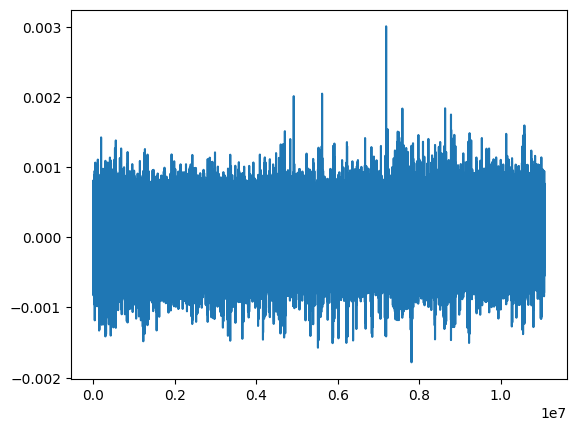

In [34]:
plt.plot(raw_sig)
plt.show()

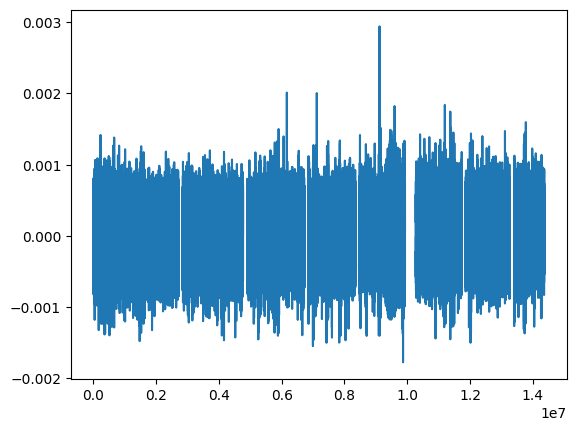

In [35]:
plt.plot(interpolated_1500hz_signal)
plt.show()

In [36]:
np.sum(np.isnan(raw_sig))

8759

/tmp/ipykernel_6411/3135350137.py:43: DeprecationWarning: 'remez' keyword argument 'Hz' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  return remez(ORDER, desired, [0, 1, 0], Hz=sampling_frequency), 1.0


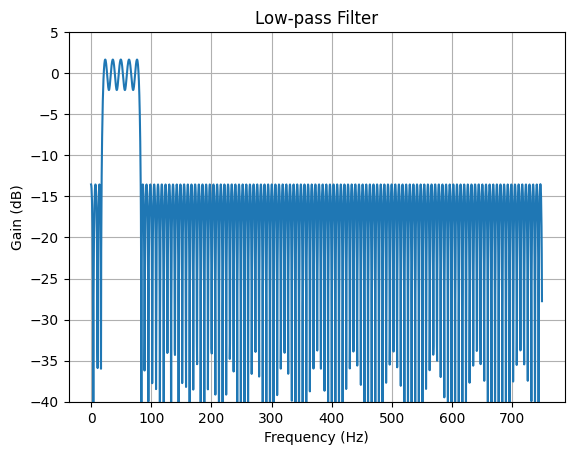

In [5]:
# gamma filter
fs = 1500

taps = make_bandpass_filter(sampling_frequency=fs, BAND_OF_INTEREST = [20, 80],
                            TRANSITION_BAND = 2.5, ORDER = 250)


w, h = signal.freqz(taps[0], [1], worN=2000, fs=fs) # this is for plotting the filter just to visualize it
plot_response(w, h, "Low-pass Filter")
plt.show()

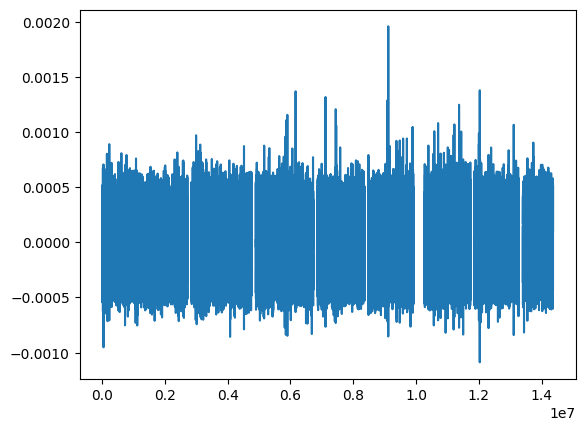

In [6]:
convolved_signal = lfilter(taps[0], taps[1], interpolated_1500hz_signal)

plt.plot(convolved_signal)
plt.show()

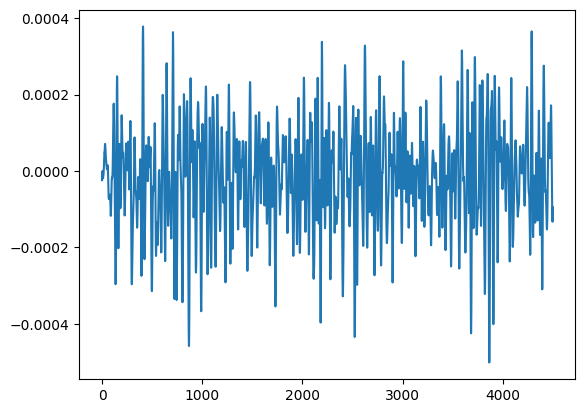

In [7]:
convolved_signal = lfilter(taps[0], taps[1], interpolated_1500hz_signal)

plt.plot(convolved_signal[0:4501])
plt.show()

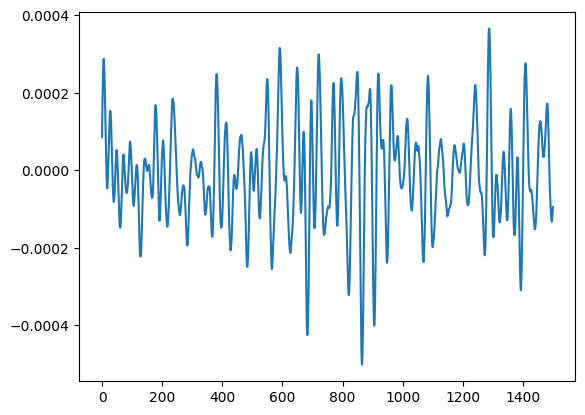

In [8]:
# plotting gamma band filtered signal from secods 3-4 (sample 3k to 4.5k) to verify it looks good
plt.plot(convolved_signal[3000:4501])
plt.show()

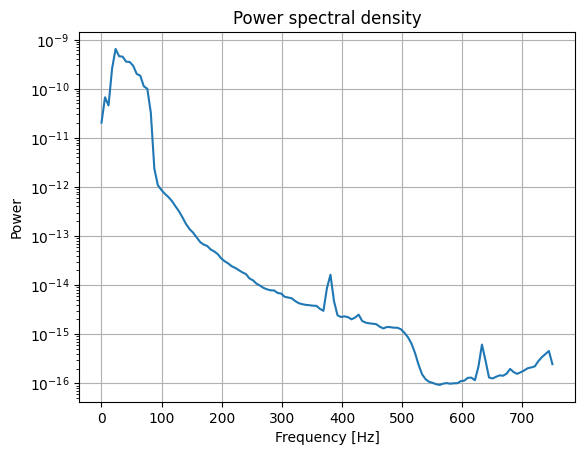

In [9]:
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

# Compute the power spectral density
frequencies, power = welch(convolved_signal[0:150000], fs=1500)

# Plot the power spectral density
plt.semilogy(frequencies, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectral density')
plt.grid(True)
plt.show()

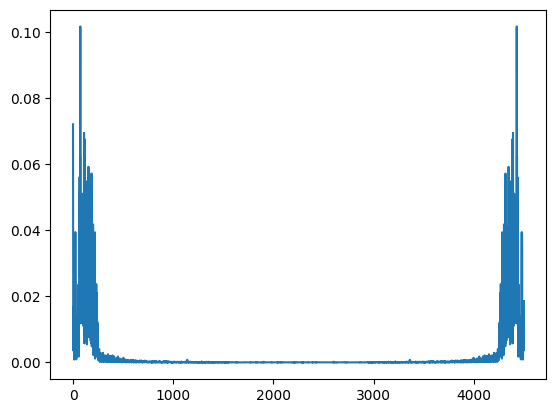

In [10]:
plt.plot(np.abs(np.fft.fft(convolved_signal[0:4501])))
plt.show()

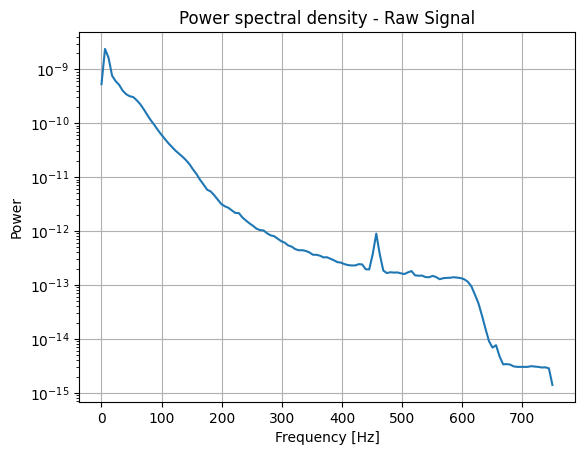

In [11]:
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

# Compute the power spectral density
#frequencies, power = welch(convolved_signal[0:150000], fs=1500)
#frequencies, power = welch(peakrippleband[0:150000], fs=1500)
frequencies, power = welch(raw_sig[0:int(150000*(1250/1500))], fs=1500)

# Plot the power spectral density
plt.semilogy(frequencies, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectral density - Raw Signal')
plt.grid(True)
plt.show()

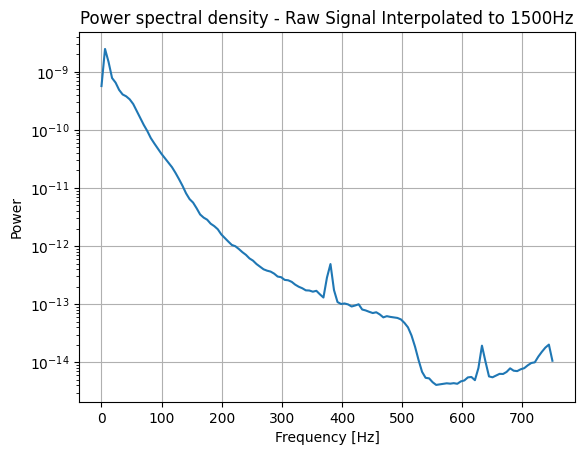

In [12]:
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

# Compute the power spectral density
frequencies, power = welch(interpolated_1500hz_signal[0:150000], fs=1500)

# Plot the power spectral density
plt.semilogy(frequencies, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectral density - Raw Signal Interpolated to 1500Hz')
plt.grid(True)
plt.show()

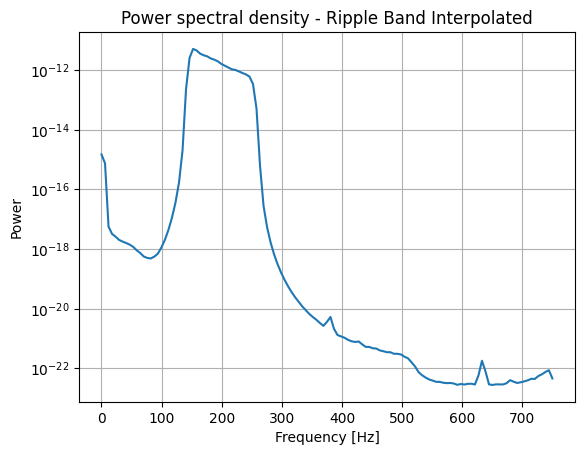

In [13]:
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

# Compute the power spectral density
frequencies, power = welch(peakrippleband[0:150000], fs=1500)


# Plot the power spectral density
plt.semilogy(frequencies, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectral density - Ripple Band Interpolated')
plt.grid(True)
plt.show()

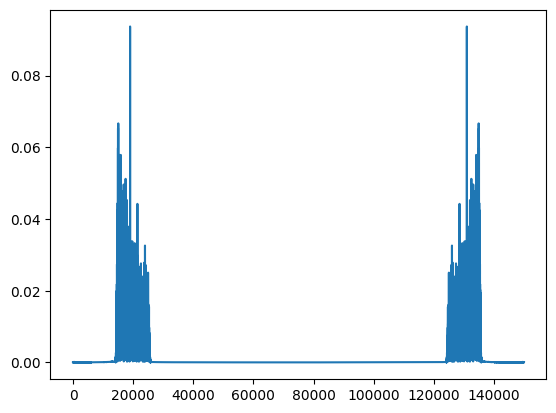

In [14]:
plt.plot(np.abs(np.fft.fft(peakrippleband[0:150000])))
plt.show()

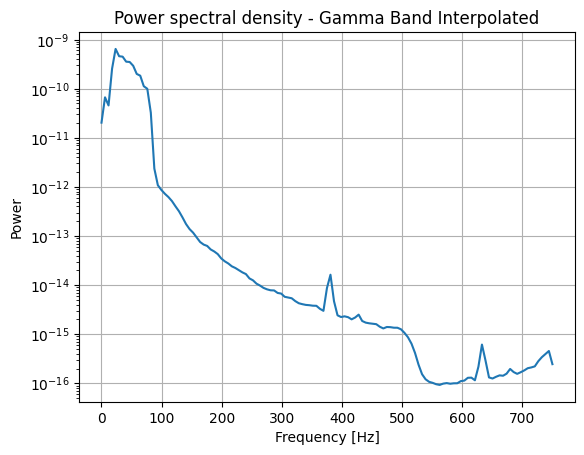

In [15]:
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

# Compute the power spectral density
frequencies, power = welch(convolved_signal[0:150000], fs=1500)


# Plot the power spectral density
plt.semilogy(frequencies, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectral density - Gamma Band Interpolated')
plt.grid(True)
plt.show()

In [16]:
from scipy.signal import firwin, lfilter


interpolated_1500hz_signal = lfp_ca1[:,highest_rip_power.argmax()]
# Define the order of the low-pass filter
numtaps = 101

# Define the cutoff frequency (in Hz) for the low-pass filter
cutoff_hz = 625.0

# Create the low-pass filter
low_pass_taps = firwin(numtaps, cutoff_hz/(0.5*1500), window='hamming')

# Apply the low-pass filter to your signal
low_passed_signal = lfilter(low_pass_taps, 1.0, interpolated_1500hz_signal)

# Now create your bandpass filter
bandpass_taps = make_bandpass_filter(sampling_frequency=1500, BAND_OF_INTEREST = [20, 80],
                            TRANSITION_BAND = 10, ORDER = 250)

# Apply the bandpass filter to the low-passed signal
bandpassed_signal = lfilter(bandpass_taps[0], bandpass_taps[1], low_passed_signal)

/tmp/ipykernel_6411/3135350137.py:43: DeprecationWarning: 'remez' keyword argument 'Hz' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  return remez(ORDER, desired, [0, 1, 0], Hz=sampling_frequency), 1.0


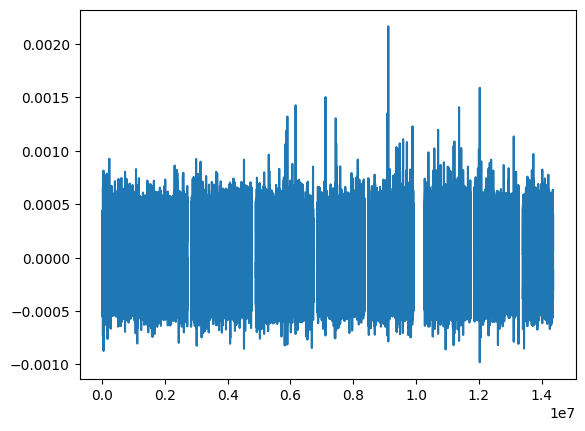

In [24]:
plt.plot(bandpassed_signal)
plt.show()

In [21]:
print(len(bandpassed_signal))
print(np.sum(np.isnan(bandpassed_signal)))

14367292
1058161


In [22]:
np.sum(np.isnan(bandpassed_signal))/len(bandpassed_signal)

0.07365069214156711

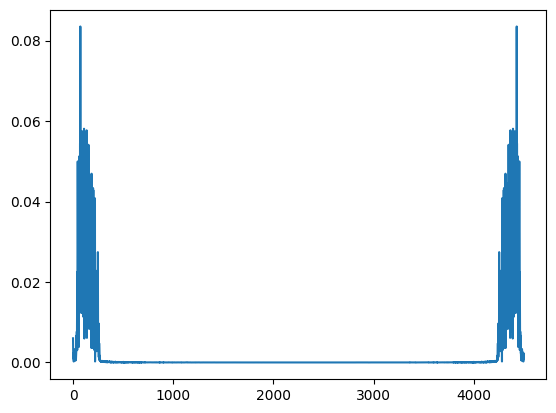

In [17]:
plt.plot(np.abs(np.fft.fft(bandpassed_signal[0:4501])))
plt.show()

In [18]:
def gamma_band_1500hzsig_filter(interpolated_1500hz_signal, 
                                filters_path = ["/home/acampbell/Stienmetz2019Reanalyzed/ExtractingSWRs/PowerBandFilters/Gamma_Band_withlowpass_Filter/lowpass_prefilter.npy",
                                                "/home/acampbell/Stienmetz2019Reanalyzed/ExtractingSWRs/PowerBandFilters/Gamma_Band_withlowpass_Filter/gamma_band_filter.npy"]):
    """
    Takes in a signal interpolated to 1500 Hz and returns the signal filtered in the gamma band, using filters designed for 1500 Hz.
    
    Parameters
    ----------
    interpolated_1500hz_signal : array_like
        The signal interpolated to 1500 Hz.
    filters_path : list of str
        The path to the filters to be used for filtering the signal.
        
    Returns
    -------
    bandpassed_signal : array_like
        The filtered signal.
        
    Notes:    
    How filters were made:
        # Define the order of the low-pass filter
        numtaps = 101

        # Define the cutoff frequency (in Hz) for the low-pass filter
        cutoff_hz = 625.0
        # Create the low-pass filter
        low_pass_taps = firwin(numtaps, cutoff_hz/(0.5*1500), window='hamming')
    
        # Now create your bandpass filter
        bandpass_taps = make_bandpass_filter(sampling_frequency=1500, BAND_OF_INTEREST = [20, 80],
                                TRANSITION_BAND = 10, ORDER = 250)
                                
    
    """
    # Create the low-pass filter
    low_pass_taps = np.load(filters_path[0])

    # Apply the low-pass filter to your signal
    low_passed_signal = lfilter(low_pass_taps, 1.0, interpolated_1500hz_signal)

    # Now create your bandpass filter
    bandpass_taps = np.load(filters_path[1])

    # Apply the bandpass filter to the low-passed signal
    bandpassed_signal = lfilter(bandpass_taps, 1.0, low_passed_signal)
    
    return bandpassed_signal

In [20]:
bandpass_taps[0]

array([-7.30878720e-03,  3.74017551e-03,  1.30431864e-03, -9.23036860e-04,
       -2.56349917e-03, -3.45279942e-03, -3.62212373e-03, -3.21636520e-03,
       -2.44810818e-03, -1.52298014e-03, -6.22566606e-04,  1.33305062e-04,
        6.69601624e-04,  9.67197123e-04,  1.03036490e-03,  8.95302384e-04,
        6.00194665e-04,  1.98501210e-04, -2.63523455e-04, -7.29564497e-04,
       -1.14686221e-03, -1.47560810e-03, -1.64486327e-03, -1.66311988e-03,
       -1.47060743e-03, -1.08435181e-03, -5.42975650e-04,  1.31226449e-04,
        8.71098605e-04,  1.59468339e-03,  2.22019187e-03,  2.69045332e-03,
        2.94790377e-03,  2.96264396e-03,  2.72953148e-03,  2.29073161e-03,
        1.70818187e-03,  1.06941698e-03,  4.63411507e-04, -8.58176678e-06,
       -2.64331710e-04, -2.36014366e-04,  9.38727299e-05,  7.22753637e-04,
        1.58345166e-03,  2.60734943e-03,  3.67377856e-03,  4.66641627e-03,
        5.46538320e-03,  5.96738707e-03,  6.09936741e-03,  5.84470052e-03,
        5.22092135e-03,  

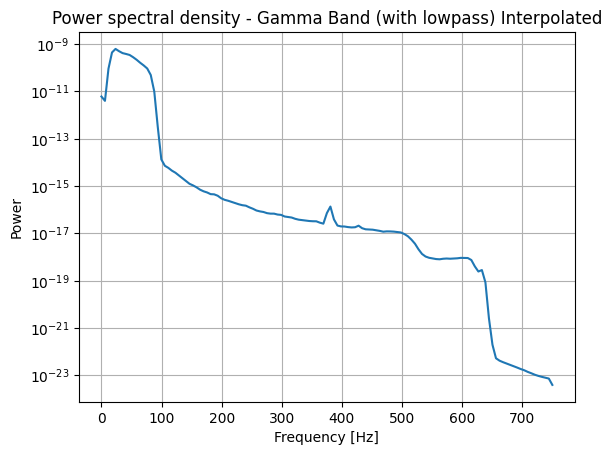

In [19]:
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

# Compute the power spectral density
frequencies, power = welch(bandpassed_signal[0:150000], fs=1500)

# Plot the power spectral density
plt.semilogy(frequencies, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectral density - Gamma Band (with lowpass) Interpolated')
plt.grid(True)
plt.show()

In [27]:
# saving the arrays
np.save("Gamma_Band_withlowpass_Filter/lowpass_prefilter.npy", low_pass_taps)
np.save("Gamma_Band_withlowpass_Filter/gamma_band_filter.npy", bandpass_taps[0])

In [31]:
# making my own ripple band filter

interpolated_1500hz_signal = lfp_ca1[:,highest_rip_power.argmax()]
# Define the order of the low-pass filter
numtaps = 101

# Define the cutoff frequency (in Hz) for the low-pass filter
# based on nyquist frequency of LFP sampling rate
cutoff_hz = 625.0

# Create the low-pass filter
low_pass_taps = firwin(numtaps, cutoff_hz/(0.5*1500), window='hamming')

# Apply the low-pass filter to your signal
low_passed_signal_ripple = lfilter(low_pass_taps, 1.0, interpolated_1500hz_signal)

# Now create your bandpass filter
bandpass_taps_ripple = make_bandpass_filter(sampling_frequency=1500, BAND_OF_INTEREST = [110, 250],
                            TRANSITION_BAND = 20, ORDER = 101)

# Apply the bandpass filter to the low-passed signal
bandpassed_signal_ripple = lfilter(bandpass_taps_ripple[0], bandpass_taps_ripple[1], low_passed_signal_ripple)

/tmp/ipykernel_63512/3135350137.py:43: DeprecationWarning: 'remez' keyword argument 'Hz' is deprecated in favour of 'fs' and will be removed in SciPy 1.12.0.
  return remez(ORDER, desired, [0, 1, 0], Hz=sampling_frequency), 1.0


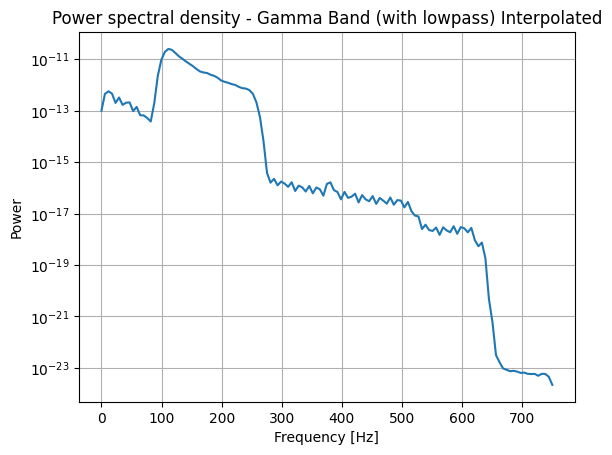

In [32]:
# Compute the power spectral density
frequencies, power = welch(bandpassed_signal_ripple[0:150000], fs=1500)

# Plot the power spectral density
plt.semilogy(frequencies, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectral density - Gamma Band (with lowpass) Interpolated')
plt.grid(True)
plt.show()

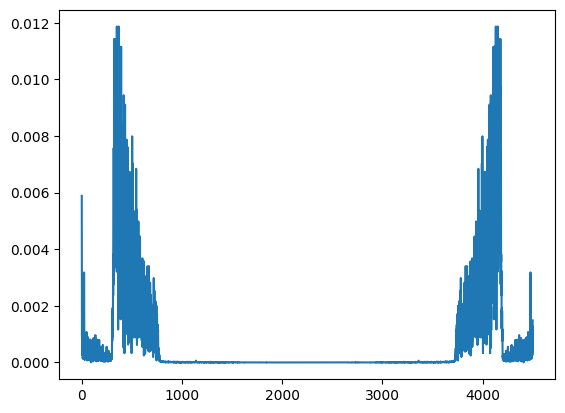

In [30]:
plt.plot(np.abs(np.fft.fft(bandpassed_signal_ripple[0:4501])))
plt.show()

In [ ]:
from scipy.signal import welch
import matplotlib.pyplot as plt
import numpy as np

# Compute the power spectral density
#frequencies, power = welch(convolved_signal[0:150000], fs=1500)
#frequencies, power = welch(peakrippleband[0:150000], fs=1500)
frequencies, power = welch(raw_sig[0:int(150000*(1250/1500))], fs=1500)

# Plot the power spectral density
plt.semilogy(frequencies, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')
plt.title('Power spectral density - Raw Signal')
plt.grid(True)
plt.show()

In [ ]:
convolved_signal = lfilter(taps[0], taps[1], noise_signal)

plt.plot(convolved_signal)
plt.show()

In [ ]:


# Setting up the ABI Cache
manifest_path = os.path.join(sdk_cache_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

# we start by calling and filtering our dataframe of the sessions we will be working with
sessions = cache.get_session_table()

if only_brain_observatory_sessions:
    sessions = sessions[sessions.session_type == 'brain_observatory_1.1']

if len(select_these_sessions)>0:
    sessions = sessions.loc[ sessions.index.intersection(select_these_sessions) ]

    
 
# Looping through the sessions specified
"""
    from tqdm import tqdm
    import time

    # Replace this with your actual loop or task
    for i in tqdm(range(10), desc="Processing", unit="iteration"):
        # Simulate some work
        time.sleep(0.1)

    print("Task completed!")
"""

# include a data frame that lists the sessions used, channels taken from each session and for what (movement vs ripples),
# and if there is behavioural data or lfp data

# Create main folder
swr_output_dir_path = os.path.join(output_dir, swr_output_dir)
os.makedirs(swr_output_dir, exist_ok=True)
sessions_without_ca1 = np.array([])

for seshnum in tqdm(range(0, sessions.shape[0]), desc="Processing", unit="iteration"):
    session_id = sessions.index.values[seshnum]
    session = cache.get_session_data(session_id)
    print("Starting Session id " + str(session_id))
    
    # check if this session even has CA1 channels in it, if not skip this iteration and add the name to the list
    sesh_has_ca1 = np.isin('CA1', list(session.channels.ecephys_structure_acronym.unique()))
    if not sesh_has_ca1:
        print("Session id " + str(session_id) + "Does not have CA1")
        sessions_without_ca1 = np.append(sessions_without_ca1, session_id)
        continue

    # Create subfolder for session, will contain all csvs for events detected and .npy of ca1 channels and control channels 
    session_subfolder = "swrs_session_" + str(session_id)
    session_subfolder = os.path.join(swr_output_dir_path, session_subfolder)
    os.makedirs(session_subfolder, exist_ok=True) 
    
    # get probes with CA1 recordings out of recording
    probe_id_list = list(session.channels.probe_id.unique())
    probes_of_interest = []

    # find probes which contain channels from CA1
    
    for probe_id in probe_id_list:
        has_ca1_and_exists = np.isin('CA1', list(session.channels[session.channels.probe_id == probe_id].ecephys_structure_acronym.unique()))
        has_ca1_and_exists = has_ca1_and_exists & session.probes.has_lfp_data[probe_id]
        if has_ca1_and_exists:
            probes_of_interest.append(probe_id)
    # create an arraey to be filled with channel ids fro ca1
    ca1_chans_arr = np.array([], dtype=int)
    used_channels_xarray_dict = {} # a list to put the lfp xarray objects into 
    
    # create an array to be filled with outside of brain controls
    outof_hp_chans_arr = np.array([], dtype=int)

    # get lfp for each probe
    for probe_id in probes_of_interest[0:1]:    
        # pull or laod the lfp for this probe
        print("Probe id " + str(probe_id))
        lfp = session.get_lfp(probe_id)
        sampling_rate_this_probe = session.probes.lfp_sampling_rate[probe_id]

        print("Selecting CA1 channel...")
        # fetching channels in ca1 on this probe for this recording
        ca1_chans =session.channels.probe_channel_number[(session.channels.probe_id==probe_id)&(session.channels.ecephys_structure_acronym=='CA1')]
        ca1_idx = np.isin(lfp.channel.values, ca1_chans.index.values)
        ca1_idx = lfp.channel.values[ca1_idx]
        
        # select ca1 channels 
        lfp_ca1  = lfp.sel(channel=ca1_idx)
        lfp_ca1  = lfp_ca1.to_pandas()
        lfp_ca1_chans  = lfp_ca1.columns
        lfp_ca1  = lfp_ca1.to_numpy()

        # get the timestamps for this lfp recording
        #lfp_time_index = lfp_ca1.index.values 
        lfp_ca1, lfp_time_index = resample_signal(lfp_ca1, lfp.time.values, 1500.0) # note the original samplig rate is infered from the times object

        #identify channel on probe with highest ripple power
        #lfp_ca1_ripppleband = finitimpresp_filter_for_LFP(lfp_ca1, samplingfreq = sampling_rate_this_probe,  lowcut = 120, highcut = 250)
        lfp_ca1_ripppleband = filter_ripple_band(lfp_ca1)
        highest_rip_power = np.abs(signal.hilbert(lfp_ca1_ripppleband))**2
        highest_rip_power = highest_rip_power.max(axis=0)
        
        # store channel identity in ca1_chans_arr and pull it for analysis of that channel
        this_chan_id = int(lfp_ca1_chans[highest_rip_power.argmax()])
        
        # ideally we would store the channels for later use, but each lfp has it's own time and sampling rate that it goes through
        #used_channels_xarray_dict[this_chan_id] = lfp.channel.values[this_chan_id]
        ca1_chans_arr = np.append(ca1_chans_arr, this_chan_id)
        peakrippleband = lfp_ca1_ripppleband[:,highest_rip_power.argmax()]
        # make fake speed variable, we can use this for now and fix it later              
        dummy_speed = np.zeros_like(peakrippleband)
        print("Detecting Putative Ripples")
        # we add a dimension to peakrippleband because the ripple detector needs it
        Karlsson_ripple_times = ripple_detection.Karlsson_ripple_detector(
            time = lfp_time_index, 
            zscore_threshold= ripple_band_threshold,
            filtered_lfps = peakrippleband[:,None], 
            speed = dummy_speed, 
            sampling_frequency = 1500.0 # reinterploate to 1500 Hz, for edno code
        )
        # there is no need for this criteria (Karlsson_ripple_times.duration>0.015)&(Karlsson_ripple_times.duration<0.25)
        # because they are already filtered for minimum duration
        # but we need to do it for maximum duration
        Karlsson_ripple_times = Karlsson_ripple_times[Karlsson_ripple_times.duration<0.25]
        print("Done")
        # adds some stuff we want to the file
        Karlsson_ripple_times['Peak_Amplitude'], Karlsson_ripple_times['Peak_Amplitude_lfpzscore'],  Karlsson_ripple_times['Peak_time'] = peaks_in_events(events=Karlsson_ripple_times, 
                                                                                                                           time_values=lfp_time_index, 
                                                                                                                           signal_values=lfp_ca1[:,highest_rip_power.argmax()])
        
        csv_filename = f"probe_{probe_id}_channel_{this_chan_id}_karlsson_detector_events.csv"
        csv_path = os.path.join(session_subfolder, csv_filename)
        Karlsson_ripple_times.to_csv(csv_path, index=True)
        print("Writing to file.")
        print("Detecting gamma events.")
        # gamma power
        # compute this later, I will have a seperate script called SWR filtering which will do this
        gamma_band = finitimpresp_filter_for_LFP(lfp_ca1[:,lfp_ca1_chans == this_chan_id], samplingfreq =  1500.0, lowcut = 20, highcut = 80)
        gamma_power = np.abs(signal.hilbert(gamma_band))**2
        gamma_times = event_boundary_detector(time = lfp_time_index, threshold_sd = gamma_event_thresh, envelope=False, 
                                      minimum_duration = 0.015, maximum_duration = float('inf'),
                                  five_to_fourty_band_power_df = gamma_band)
        print("Done")
        csv_filename = f"probe_{probe_id}_channel_{this_chan_id}_gamma_band_events.csv"
        csv_path = os.path.join(session_subfolder, csv_filename)
        gamma_times.to_csv(csv_path, index=True)
        print("Writing to file.")
        print("Selecting reference channel for movement artifact filtering.")
        # movement artifact detector channel (SWR bandpass and power, then z-score)
        # control_region_idx = session.channels.ecephys_structure_acronym.isna()
        
        # as detailed in supplementry methods in Nitzan et al., (2022) on page 2 under Event Detection
        """"
        An additional ‘noise’ signal from a channel outside of the hippocampus was provided to exclude
        simultaneously occurring high frequency events. 
        """
        # So we will pick a channel from outside hippocampus to filter for high frequency events as well
        # if there is no non hippocampal non-cortical region 
        idx = session.channels.probe_id == probe_id
        organisedprobechans = session.channels[idx].sort_values(by='probe_vertical_position')
        organisedprobechans = organisedprobechans[np.isin(organisedprobechans.index.values, lfp.channel.values) ]

        # code for identifying first  and last ca1 channel, not used now but can be later to pick channels above or below ca1
        # first_ca1 = organisedprobechans.probe_vertical_position[organisedprobechans.ecephys_structure_acronym == 'CA1'].tolist()[-1]
        # last_ca1 = organisedprobechans.probe_vertical_position[organisedprobechans.ecephys_structure_acronym == 'CA1'].tolist()[0]
        
        not_a_ca1_chan = np.logical_not(np.isin(organisedprobechans.ecephys_structure_acronym,[ "CA3", "CA2", "CA1", "HPF", "EC", "DG"]))

        # Find the indices of the blocks of False i.e. the channels that are ca1
        take_two = np.random.choice(organisedprobechans.index[not_a_ca1_chan], 2, replace=False)
        outof_hp_chans_arr = np.append(outof_hp_chans_arr,take_two)
        
        # movement control
        for channel_outside_hp in take_two:
            movement_control_channel = lfp.sel(channel=channel_outside_hp)
            movement_control_channel = movement_control_channel.to_numpy()
            # select ca1 channels
            interp_func = interpolate.interp1d(lfp.time.values, movement_control_channel)
            movement_control_channel = interp_func(lfp_time_index)
            #movement_control_channel = finitimpresp_filter_for_LFP(movement_control_channel,samplingfreq=sampling_rate_this_probe, lowcut = 120, highcut = 250)
            movement_control_channel = filter_ripple_band(movement_control_channel[:,None])

            dummy_speed = np.zeros_like(movement_control_channel)

            movement_controls = ripple_detection.Karlsson_ripple_detector(
                time = lfp_time_index.reshape(-1),
                filtered_lfps = movement_control_channel,
                speed = dummy_speed.reshape(-1),
                zscore_threshold= movement_artifact_ripple_band_threshold,
                sampling_frequency = 1500.0
            )
            print("Done")
            csv_filename = f"probe_{probe_id}_channel_{channel_outside_hp}_movement_artifacts.csv"
            csv_path = os.path.join(session_subfolder, csv_filename)
            movement_controls.to_csv(csv_path, index=True)
            print("Done Probe id " + str(probe_id))
        
        #write these two to a numpy array finish loop
        # write channel number and sessionid to a pandas array tracking where each channel came from
        # so at the end of the loop you can identify which channel it called
    
    # save channels used in the session to detect SWR events (also gamma events) and channels for movement artifact detection
    # Save numpy arrays to the file
    txt_np_arr_filename_swr = f"session_{session_id}_channel_{this_chan_id}_ca1_channels.txt"
    nptxt_path = os.path.join(session_subfolder, txt_np_arr_filename_swr)
    np.savetxt(nptxt_path, ca1_chans_arr, fmt='%d', delimiter=',')

    txt_np_arr_filename_move = f"session_{session_id}_channel_{this_chan_id}_outofbrain_channels.txt"
    nptxt_path = os.path.join(session_subfolder, txt_np_arr_filename_move)
    np.savetxt(nptxt_path, outof_hp_chans_arr, fmt='%d', delimiter=',')
    print("Done Session id " + str(session_id))
    #loop over global channels
    # needs changing to all channels
    # this is difficult because the samples need to be interpolated between and matched
    """
    used_channels_xarray_dict[this_chan_id].append(lfp.channel.values[this_chan_id]).keys()
    this_chan_id + used_channels_xarray_dict
    
    Karlsson_ripple_times = ripple_detection.Karlsson_ripple_detector(
            time = lfp_time_index, 
            filtered_lfps = lfp.sel(channel=ca1_chans_arr), 
            speed = dummy_speed, 
            sampling_frequency = 1250.0)
    
    # save to 
    csv_filename = f"global_session_{session_id}_karlsson_detector_events.csv"
    csv_path = os.path.join(session_subfolder, csv_filename)
    Karlsson_ripple_times.to_csv(csv_path, index=True)
    """
    
    # removing files
    # replace path/to/directory with cache and session info for this loop
    if (session_id not in dont_wipe_these_sessions):
        remove_from_path_command = "find "+sdk_cache_dir+"/session_"+str(session_id)+" -type f -name '*lfp*' -exec rm {} +"
        call_bash_function(remove_from_path_command)

# saving the sessions that don't contain any channels in CA1
txt_np_arr_filename_move = "session_without_ca1.txt"
nptxt_path = os.path.join(swr_output_dir_path, txt_np_arr_filename_move)
np.savetxt(nptxt_path, sessions_without_ca1, fmt='%d', delimiter=',')

print("Done! Results in " + swr_output_dir_path)

Processing:   0%|          | 0/1 [00:00<?, ?iteration/s]

Starting Session id 715093703
Probe id 810755801
Selecting CA1 channel...
Detecting Putative Ripples
Done
Writing to file.
Detecting gamma events.
Done
Writing to file.
Selecting reference channel for movement artifact filtering.
Done
Done Probe id 810755801


Processing: 100%|██████████| 1/1 [04:29<00:00, 269.18s/iteration]

Done
Done Probe id 810755801
Done Session id 715093703
Bash function executed successfully.
Output: 
Done! Results in /space/scratch/allen_visbehave_swr_data/testing_dir


In [10]:
movement_control_channel.shape

(11070604,)

In [6]:
# select ca1 channels 
lfp_ca1  = lfp.sel(channel=ca1_idx)
lfp_ca1  = lfp_ca1.to_pandas()
lfp_ca1_chans  = lfp_ca1.columns
lfp_ca1  = lfp_ca1.to_numpy()

# get the timestamps for this lfp recording
#lfp_time_index = lfp_ca1.index.values 
lfp_ca1, lfp_time_index = resample_signal(lfp_ca1, lfp.time.values, 1500.0)

In [4]:
lfp_ca1.shape

(11070604, 20)

In [ ]:
import numpy as np
from scipy import interpolate

def resample_signal(signal, times, new_rate):
    """
    Resample a 2D signal array to a new sampling rate.

    Parameters:
    signal (np.array): 2D array where each row is a source and each column is a time point.
    times (np.array): 1D array of times corresponding to the columns of the signal array.
    new_rate (float): The new sampling rate in Hz.

    Returns:
    new_signal (np.array): The resampled signal array.
    new_times (np.array): The times corresponding to the columns of the new signal array.
    """
    # Calculate the number of samples for the new rate
    nsamples_new = int(len(times) * new_rate / (len(times) / times[-1]))

    # Create a new time array for the new rate
    new_times = np.linspace(times[0], times[-1], nsamples_new)

    # Initialize an empty array for the new signal
    new_signal = np.zeros((signal.shape[0], nsamples_new))

    # Interpolate each source separately
    for i in range(signal.shape[0]):
        interp_func = interpolate.interp1d(times, signal[i, :])
        new_signal[i, :] = interp_func(new_times)

    return new_signal, new_times